# Image classification with EANet

<hr />

### Introduction

This example implements the EANet model for image classification, and demonstrates it on the CIFAR-100 dataset. EANet introduces a novel attention mechanism named <b>external attention</import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt
b>, based on two external, small, learnable, and shared memories, which can be implemented easily by simply using two cascaded linear layers and two normalization layers. It conveniently replaces self-attention as used in existing architectures. External attention has linear complexity, as it only implicitly considers the correlations between all samples.

<hr />

### Setup

In [1]:
import keras
from keras import layers
from keras import ops

import matplotlib.pyplot as plt

2025-04-22 03:17:49.326616: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745291869.371854  153565 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745291869.386645  153565 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745291869.422868  153565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745291869.422910  153565 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745291869.422913  153565 computation_placer.cc:177] computation placer alr

<hr />

### Prepare the data

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 100)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 100)


<hr />

### Configure the hyperparameters

In [3]:
weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
validation_split = 0.2
batch_size = 128
num_epochs = 50
patch_size = 2  # Size of the patches to be extracted from the input images.
num_patches = (input_shape[0] // patch_size) ** 2  # Number of patch
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
dim_coefficient = 4
num_heads = 4
attention_dropout = 0.2
projection_dropout = 0.2
num_transformer_blocks = 8  # Number of repetitions of the transformer layer

print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")

Patch size: 2 X 2 = 4 
Patches per image: 256


<hr />

### Use data augmentation

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.1),
        layers.RandomContrast(factor=0.1),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2025-04-22 03:18:58.415288: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


<hr />

### Implement the patch extraction and encoding layer

In [5]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        B, C = ops.shape(x)[0], ops.shape(x)[-1]
        x = ops.image.extract_patches(x, self.patch_size)
        x = ops.reshape(x, (B, -1, self.patch_size * self.patch_size * C))
        return x


class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        pos = ops.arange(start=0, stop=self.num_patch, step=1)
        return self.proj(patch) + self.pos_embed(pos)

<hr />

### Implement the external attention block

In [6]:
def external_attention(
    x,
    dim,
    num_heads,
    dim_coefficient=4,
    attention_dropout=0,
    projection_dropout=0,
):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = layers.Dense(dim * dim_coefficient)(x)
    # create tensor [batch_size, num_patches, num_heads, dim*dim_coefficient//num_heads]
    x = ops.reshape(x, (-1, num_patch, num_heads, dim * dim_coefficient // num_heads))
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    # a linear layer M_k
    attn = layers.Dense(dim // dim_coefficient)(x)
    # normalize attention map
    attn = layers.Softmax(axis=2)(attn)
    # dobule-normalization
    attn = layers.Lambda(
        lambda attn: ops.divide(
            attn,
            ops.convert_to_tensor(1e-9) + ops.sum(attn, axis=-1, keepdims=True),
        )
    )(attn)
    attn = layers.Dropout(attention_dropout)(attn)
    # a linear layer M_v
    x = layers.Dense(dim * dim_coefficient // num_heads)(attn)
    x = ops.transpose(x, axes=[0, 2, 1, 3])
    x = ops.reshape(x, [-1, num_patch, dim * dim_coefficient])
    # a linear layer to project original dim
    x = layers.Dense(dim)(x)
    x = layers.Dropout(projection_dropout)(x)
    return x

<hr />

### Implement the MLP block

In [7]:
def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = layers.Dense(mlp_dim, activation=ops.gelu)(x)
    x = layers.Dropout(drop_rate)(x)
    x = layers.Dense(embedding_dim)(x)
    x = layers.Dropout(drop_rate)(x)
    return x

<hr />

### Implement the Transformer block

In [8]:
def transformer_encoder(
    x,
    embedding_dim,
    mlp_dim,
    num_heads,
    dim_coefficient,
    attention_dropout,
    projection_dropout,
    attention_type="external_attention",
):
    residual_1 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    if attention_type == "external_attention":
        x = external_attention(
            x,
            embedding_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
        )
    elif attention_type == "self_attention":
        x = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dim,
            dropout=attention_dropout,
        )(x, x)
    x = layers.add([x, residual_1])
    residual_2 = x
    x = layers.LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = layers.add([x, residual_2])
    return x

<hr />

### Implement the EANet model

The EANet model leverages external attention. The computational complexity of traditional self attention is O(d * N ** 2), where d is the embedding size, and N is the number of patch. the authors find that most pixels are closely related to just a few other pixels, and an N-to-N attention matrix may be redundant. So, they propose as an alternative an external attention module where the computational complexity of external attention is O(d * S * N). As d and S are hyper-parameters, the proposed algorithm is linear in the number of pixels. In fact, this is equivalent to a drop patch operation, because a lot of information contained in a patch in an image is redundant and unimportant.

In [9]:
def get_model(attention_type="external_attention"):
    inputs = layers.Input(shape=input_shape)
    # Image augment
    x = data_augmentation(inputs)
    # Extract patches.
    x = PatchExtract(patch_size)(x)
    # Create patch embedding.
    x = PatchEmbedding(num_patches, embedding_dim)(x)
    # Create Transformer block.
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(
            x,
            embedding_dim,
            mlp_dim,
            num_heads,
            dim_coefficient,
            attention_dropout,
            projection_dropout,
            attention_type,
        )

    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

<hr />

### Train on CIFAR-100

In [10]:
model = get_model(attention_type="external_attention")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing),
    optimizer=keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    ),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
        keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
    ],
)

history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=num_epochs,
    validation_split=validation_split,
)

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1074s 3s/step - accuracy: 0.0379 - loss: 4.4870 - top-5-accuracy: 0.1401 - val_accuracy: 0.0565 - val_loss: 4.8227 - val_top-5-accuracy: 0.1943
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1083s 3s/step - accuracy: 0.0972 - loss: 4.0488 - top-5-accuracy: 0.2945 - val_accuracy: 0.0895 - val_loss: 4.5374 - val_top-5-accuracy: 0.2703
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1792s 6s/step - accuracy: 0.1402 - loss: 3.8403 - top-5-accuracy: 0.3781 - val_accuracy: 0.0984 - val_loss: 4.5305 - val_top-5-accuracy: 0.2966
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1076s 3s/step - accuracy: 0.1607 - loss: 3.7454 - top-5-accuracy: 0.4092 - val_accuracy: 0.1193 - val_loss: 4.4033 - val_top-5-accuracy: 0.3372
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1073s 3s/step - accuracy: 0.1815 - loss: 3.6410 - top-5-accuracy: 0.4459 - val_accuracy: 0.1082 - val_loss: 4.6859 - val_top-5-accuracy: 0.3290
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 1066s 3s/step - accuracy: 0.1947 - loss:

#### Let's visualize the training progress of the model.

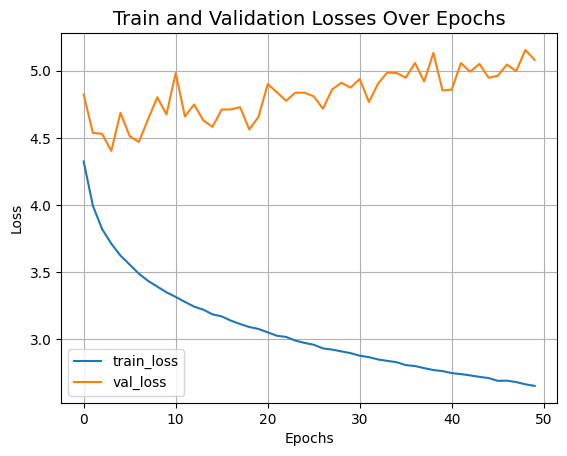

In [11]:
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Train and Validation Losses Over Epochs", fontsize=14)
plt.legend()
plt.grid()
plt.show()

#### Let's display the final results of the test on CIFAR-100.

In [12]:
loss, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test loss: {round(loss, 2)}")
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 62s 198ms/step - accuracy: 0.1705 - loss: 5.0689 - top-5-accuracy: 0.4012
Test loss: 5.08
Test accuracy: 17.05%
Test top 5 accuracy: 39.96%


EANet just replaces self attention in Vit with external attention. The traditional Vit achieved a ~73% test top-5 accuracy and ~41 top-1 accuracy after training 50 epochs, but with 0.6M parameters. Under the same experimental environment and the same hyperparameters, The EANet model we just trained has just 0.3M parameters, and it gets us to ~73% test top-5 accuracy and ~43% top-1 accuracy. This fully demonstrates the effectiveness of external attention.

We only show the training process of EANet, you can train Vit under the same experimental conditions and observe the test results.